In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
from utils.show_image import imshow
from torchvision import utils
from models import Sinkhorn_DCGAN_D,DCGAN_G,MLP_G,MLP_D
from utils.sinkhorn_loss import sinkhorn_loss
import sys
import pickle

In [2]:
z_size=2
hidden_size=256
batch_size = 64
dataset_name="MNIST"
output_dimension=100
niter=10
use_cuda=torch.cuda.is_available()
print('Use cuda: %r'%use_cuda)

Use cuda: False


In [3]:
if dataset_name == 'MNIST':
    total_epoch=10000
    img_size=32
    image_chanel = 1
    epsilon=1
    model_name = 'Sinkhorn_MLP_MNIST'
    root = './data/mnist/'
    download = True
    trans = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    data_set = dset.MNIST(
        root=root, transform=trans, download=download)
if dataset_name == "LSUN":
    total_epoch=100000
    img_size=64
    image_chanel = 3
    epsilon=10
    model_name = 'Sinkhorn_MLP_LSUN'
    root = './data/lsun/'
    trans = transforms.Compose([
        transforms.Scale(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    data_set = dset.LSUN(
        db_path=root, classes=['bedroom_train'], transform=trans)
if dataset_name == 'CIFAR':
    total_epoch=10000
    img_size=32
    image_chanel = 1
    model_name = 'Sinkhorn_MLP_CIFAR'
    root = './data/cifar10/'
    download = True
    trans = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    data_set = dset.MNIST(
        root=root, transform=trans, download=download)

In [4]:
data_loader = torch.utils.data.DataLoader(
        dataset=data_set, batch_size=batch_size, shuffle=True)

In [5]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
mone = one * -1
fixed_noise = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0, 1)
if use_cuda:
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
    fixed_noise=fixed_noise.cuda()
    mone=mone.cuda()

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
from tqdm import tqdm
G = MLP_G(isize=img_size, nz=z_size, nc=image_chanel, ngf=hidden_size, ngpu=0)
G.apply(weights_init)
D = MLP_D(isize=img_size, nz=z_size, nc=image_chanel, ndf=hidden_size, ngpu=0)
D.apply(weights_init)
print(G)
print(D)
# if len(sys.argv)==3:
#     G.load_state_dict(torch.load(sys.argv[1]))
#     D.load_state_dict(torch.load(sys.argv[2]))
if use_cuda:
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-3
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
data_iter=iter(data_loader)
errs_real=[]
errs_fake=[]
def training():
    for epoch in tqdm(range(total_epoch)):
#         for p in D.parameters():
#             p.requires_grad = True
#         if epoch<25 or epoch%500==0:
#             iter_D=100
#         else:
#             iter_D=5
#         tmp_err_real=[]
#         for _ in range(iter_D):
#             for p in D.parameters():
#                 p.data.clamp_(-0.01, 0.01)
#             optimizers['D'].zero_grad()
#             try:
#                 data=data_iter.next()[0]
#             except:
#                 data_iter=iter(data_loader)
#                 data=data_iter.next()[0]
#             if use_cuda:
#                 data=data.cuda()
#             input_holder.resize_as_(data).copy_(data)
#             Y = D(Variable(data))
#             noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
#             noisev = Variable(noise_holder,volatile=True)
#             fake_data = Variable(G(noisev).data)
#             X = D(fake_data)
#             XY=sinkhorn_loss(X,Y,epsilon,data.size()[0],niter,use_cuda)
#             XX=sinkhorn_loss(X,X,epsilon,data.size()[0],niter,use_cuda)
#             YY=sinkhorn_loss(Y,Y,epsilon,data.size()[0],niter,use_cuda)
#             loss_real=2*XY-XX-YY
#             if use_cuda:
#                 tmp_err_real.append(loss_real.cpu().data.numpy()[0])
#             else:
#                 tmp_err_real.append(loss_real.data.numpy()[0])
#             loss_real.backward(mone)
#             optimizers['D'].step()
        
#         errs_real.append(tmp_err_real)
#         print(errs_real)
#         for p in D.parameters():
#             p.requires_grad = False
        optimizers['G'].zero_grad()
        try:
            data=data_iter.next()[0]
        except:
            data_iter=iter(data_loader)
            data=data_iter.next()[0]
        if use_cuda:
            data=data.cuda()
        input_holder.resize_as_(data).copy_(data)
        Y = D(Variable(data))
        noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
        noisev = Variable(noise_holder)
        fake_data = G(noisev)
        X = D(fake_data)
        XY=sinkhorn_loss(X,Y,epsilon,data.size()[0],niter,use_cuda)
        XX=sinkhorn_loss(X,X,epsilon,data.size()[0],niter,use_cuda)
        YY=sinkhorn_loss(Y,Y,epsilon,data.size()[0],niter,use_cuda)
        loss_fake=2*XY-XX-YY
        if use_cuda:
            errs_fake.append(loss_fake.cpu().data.numpy()[0])
        else:
            errs_fake.append(loss_fake.data.numpy()[0])
        loss_fake.backward(one)
        optimizers['G'].step()

        if epoch % 10 == 0:
            noisev = Variable(fixed_noise,volatile=True)
            fake_data = G(noisev)
            if use_cuda:
                dd = fake_data.cpu().data[:64]
            else:
                dd = fake_data.data[:64]
            dd = dd.mul(0.5).add(0.5)
            vutils.save_image(dd, './results/%s_%0.2f_%d.png'%(model_name,epsilon,epoch))
            torch.save(G.state_dict(), './results/G_epoch_%0.2f_%d.pth'%(epsilon,epoch))
            torch.save(D.state_dict(), './results/D_epoch_%0.2f_%d.pth'%(epsilon,epoch))
            pickle.dump([errs_fake,errs_real], open('./results/%s_%0.2f_loss.pkl'%(model_name,epsilon),'wb'))

training()

  0%|          | 0/10000 [00:00<?, ?it/s]

MLP_G (
  (main): Sequential (
    (0): Linear (2 -> 256)
    (1): ReLU (inplace)
    (2): Linear (256 -> 256)
    (3): ReLU (inplace)
    (4): Linear (256 -> 256)
    (5): ReLU (inplace)
    (6): Linear (256 -> 1024)
    (7): Tanh ()
  )
)
MLP_D (
  (main): Sequential (
    (0): Linear (1024 -> 256)
    (1): ReLU (inplace)
    (2): Linear (256 -> 256)
    (3): ReLU (inplace)
    (4): Linear (256 -> 256)
    (5): ReLU (inplace)
    (6): Linear (256 -> 1)
  )
)


  1%|▏         | 142/10000 [01:58<2:17:26,  1.20it/s]

In [27]:
from matplotlib import pyplot as plt
import numpy

In [28]:
a,b=pickle.load(open('./results/Sinkhorn_MLP_MNIST_0.10_loss.pkl','rb'),encoding='latin1')

In [29]:
bb=[]
for i in b:
    bb.append(numpy.mean(i))

/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


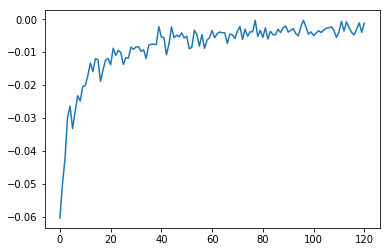

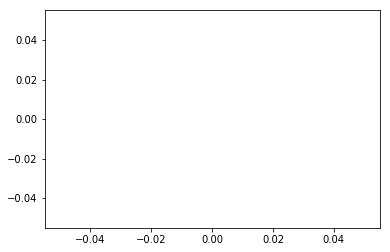

In [30]:
plt.plot(a[:1000])
plt.show()
plt.plot(bb[:100000])
plt.show()

In [38]:
bb=[]
for i in b:
    bb.append(numpy.mean(i))